In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [2]:
# Command to use the full widht of the screen
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }/style>"))

In [3]:
def BACN(init_nodes, final_nodes, m_param, l_param=0, CN=False):
    assert init_nodes > 1
    assert init_nodes < final_nodes
    assert init_nodes >= m_param
    assert l_param >= 0
    start = time.time()
    A = np.zeros((final_nodes, final_nodes)) 
    for i in range(init_nodes):
        for j in range(i+1, init_nodes):
            A[i,j] = 1
            A[j,i] = 1
    for i in range(init_nodes, final_nodes):
        p_deg_target = np.sum(A[:i,:], axis=1)
        p_deg_target /= np.sum(p_deg_target)
        p_deg_source = np.sum(A[:,:i], axis=0)
        p_deg_source /= np.sum(p_deg_source)
        rand_target = np.random.choice(i, size=m_param, p=p_deg_target, replace=False)
        A[rand_target, i] = 1
        rand_source = np.random.choice(i, size=m_param, p=p_deg_source, replace=False)
        A[i, rand_source] = 1 
        if CN and l_param > 0:
            S = A[:i+1,:i+1]
            cn_mat = S @ S
            S[np.eye(S.shape[0], dtype=bool)] = -1
            missing = np.nonzero(S==0)
            if missing[0].size/2 >= l_param:
                p_cn = cn_mat[missing]
                p_cn /= np.sum(p_cn)
                if np.isnan(p_cn).all():
                    rand_edge = np.random.choice(missing[0].size, size=l_param)
                else:
                    rand_edge = np.random.choice(missing[0].size, size=l_param, p=p_cn)
                a = missing[0][rand_edge]
                b = missing[1][rand_edge]
                A[a,b] = 1
                S[np.eye(S.shape[0], dtype=bool)] = 0
            S[np.eye(S.shape[0], dtype=bool)] = 0
    end = time.time()
    #print('Elapsed time:', end - start, 'seconds')
    return A

In [4]:
BACN(3,6,1,2,CN=True)

array([[0., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [5]:
final_nodes = 6
init_nodes = 3
A = np.zeros((final_nodes, final_nodes)) 
for i in range(init_nodes):
    for j in range(i+1, init_nodes):
        A[i,j] = 1
        A[j,i] = 1
A

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [6]:
def compute_cn(x, links):
    s = links.shape[0]
    cn = np.zeros(s)
    neighbors = {i:np.argwhere(x[i]) for i in range(x.shape[0])}
    for i in range(s):
        inter = np.intersect1d(neighbors[links[i,0]], neighbors[links[i,1]])
        cn[i] = inter.size
    return cn

In [7]:
def get_links_to_del(x, fraction=0.1, loops=1):
    present = np.argwhere(np.triu(x, 1) == 1)
    num_to_del = int(present.shape[0] * fraction)
    idx_to_del = [np.random.choice(present.shape[0], size=num_to_del, replace=False) for i in range(loops)]
    links_to_del = np.array([present[idx] for idx in idx_to_del])
    return links_to_del

In [8]:
def delete_links(x, links_to_del):
    """Deletes the specified links from an adjacency matrix."""
    z = np.copy(x)
    for link in links_to_del:
        z[link[0], link[1]] = 0
    return z

In [9]:
def evaluate_predictions(true, pred, plot=False):
    precision, recall, _ = precision_recall_curve(true, pred)
    fpr, tpr, _ = roc_curve(true, pred)
    aupr = auc(recall, precision)
    auroc = auc(fpr, tpr)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(recall, precision, 'go', label='Precision-Recall curve')
        ax.plot(fpr, tpr, '.', label='ROC curve')
        plt.legend()
        plt.show()
    return aupr, auroc

In [10]:
def cross_val_from_notebook(adjacency, links_to_del, loops=1, raw_output=False, verbose=False, plot=False):
    if raw_output:
        scores_list = []
        true_list = []
    else:
        results = np.zeros((loops, 2))
    for i in range(loops):
        if verbose:
            print('Trial {} of {}'.format(i+1, loops))
        x_ = delete_links(adjacency, links_to_del[i])
        missing = np.argwhere(x_ == 0)
        not_false = adjacency[missing[:,0], missing[:,1]]
        scores = compute_cn(x_, missing)
        if raw_output:
            scores_list.append(scores)
            true_list.append(not_false)
        else:
            results[i] = evaluate_predictions(not_false, scores, plot=plot)
    if raw_output:
        return np.array(true_list).flatten(), np.asarray(scores_list).flatten()
    else:
        return results

In [11]:
def running_all_parameters(init_nodes, final_nodes, l, loops=10, CN=False):
    fraction = 0.1
    raw_output=False
    verbose = False
    plot = False
    areas_under_curves = np.zeros((init_nodes+1, 2))
    for m in range(init_nodes+1):
        start = time.time()
        B = BACN(init_nodes, final_nodes, m, l, CN)
        links_to_del = get_links_to_del(B, fraction=fraction, loops=loops)
        r1 = cross_val_from_notebook(B, links_to_del)#, loops=loops, raw_output=raw_output, verbose=verbose, plot=plot)
        areas_under_curves[m,:] = np.mean(r1, axis=0)
        end = time.time()
    return areas_under_curves

In [12]:
def ploting_all_parameters(final, lmax, loops, CN):
    for i in range(2, final):
        start = time.time()
        plt.figure(figsize=(20,3))
        for j in range(1, lmax+1):
            r_p = running_all_parameters(i, final, j-1, loops, CN)
            plt.subplot(1,lmax,j)
            plt.title("Initial:{}, final:{}\nCN-parm:{}".format(i, final, j))
            plt.xlabel("m parameter")
            plt.plot(r_p[:,0], 'bx--', label='AUPR')
            plt.plot(r_p[:,1], 'ro--', label='AUROC')
            plt.legend()
        plt.show()
        end = time.time()

/home/jorge/anaconda2/envs/newenviroment/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/jorge/anaconda2/envs/newenviroment/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/jorge/anaconda2/envs/newenviroment/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


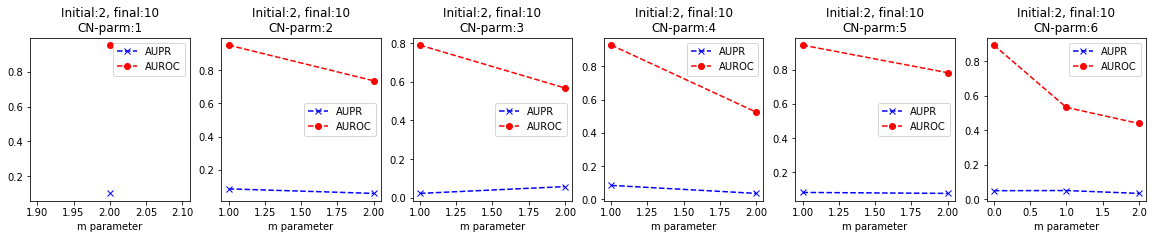

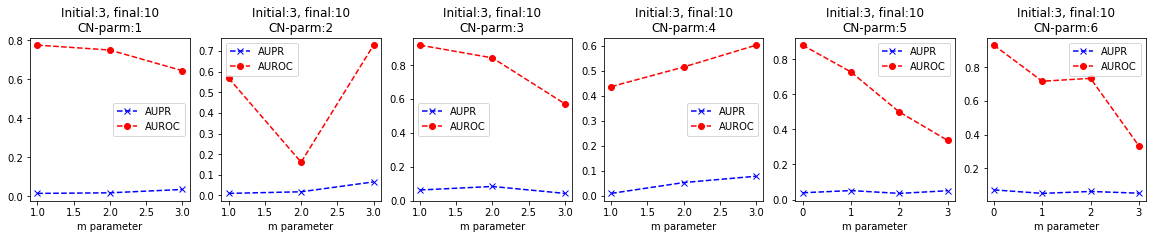

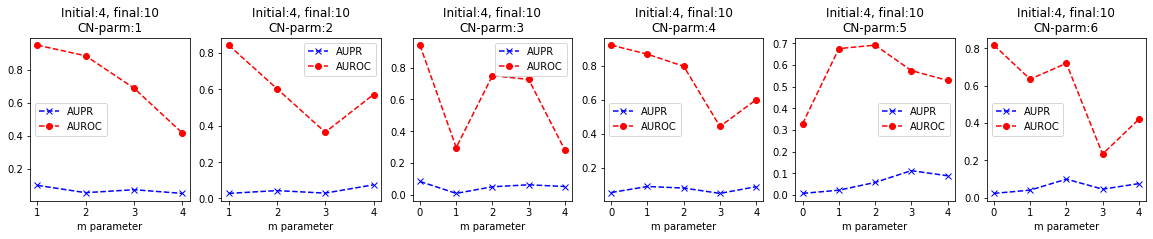

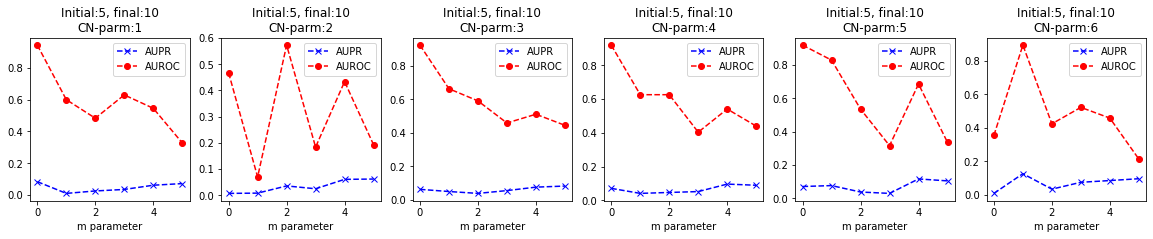

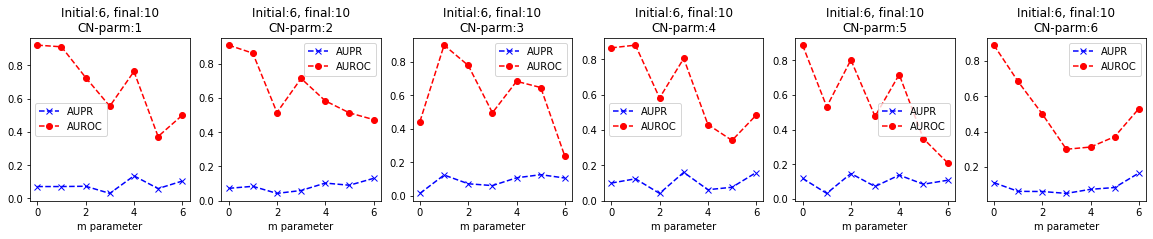

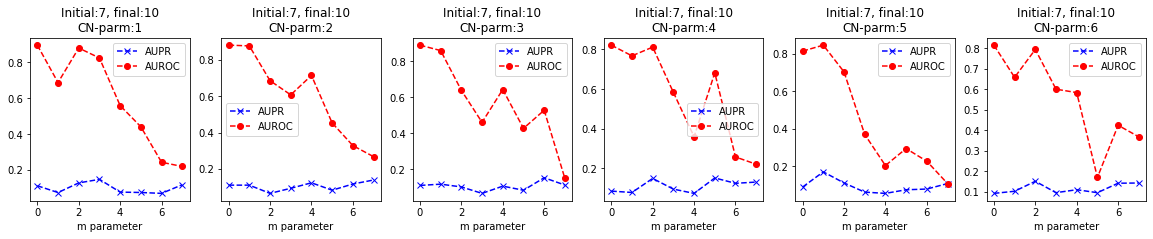

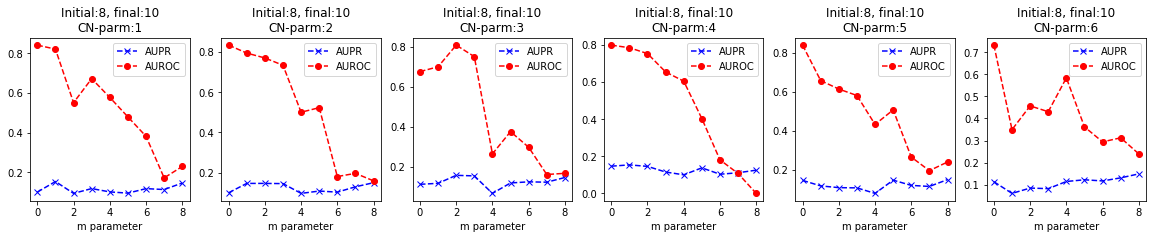

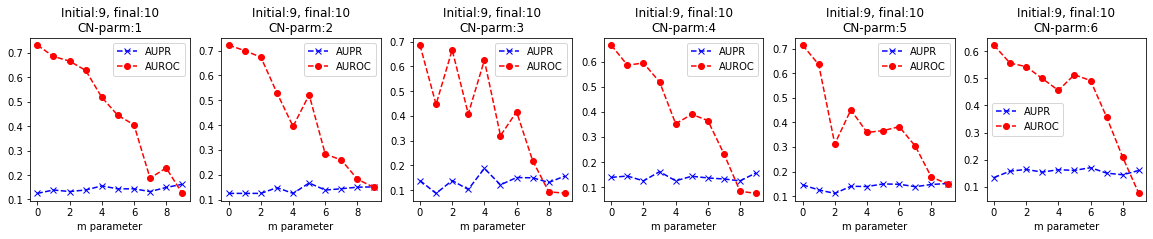

In [13]:
ploting_all_parameters(final=10, lmax=6, loops=1, CN=True)